In [1]:
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from shapely import LineString, Polygon, intersection, Point, MultiLineString, GeometryCollection
import numpy as np
import random

# Load and Clean the Data

In [2]:
G_original = ox.load_graphml('Las_Vegas_street_network.graphml')

In [3]:
debug = False

# For Tokyo, debug
# min_lat, max_lat = 35.683743, 35.700187
# min_lon, max_lon = 139.755065, 139.777357

# For No boundaries
min_lat, max_lat = -360.0, 360.0
min_lon, max_lon = -360.0, 360.0

In [4]:
nodes_of_interest = {}
for node, data in tqdm(G_original.nodes(data=True), desc="Data Cleaning"):
    if min_lat <= data['y'] <= max_lat and min_lon <= data['x'] <= max_lon:
        degree = G_original.degree[node]
        if degree != 2:
            # only keep x and y attributes for each node
            data = {"x": data['x'], "y": data['y'], "degree": degree}
            nodes_of_interest[node] = data

G = G_original.subgraph(nodes_of_interest).copy()
del G_original

Data Cleaning: 100%|██████████| 23286/23286 [00:00<00:00, 966202.33it/s]


In [5]:
if debug:
    fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=1, figsize=(9, 9), node_color="red")

# Detecting Degree-2 Keynodes 

In [6]:
def calculate_angle(p1, p2, p3):
    """Calculate the angle (in degrees) between points n1, n2, and n3."""
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    # Vector from n2 to n1
    v1 = (x1 - x2, y1 - y2)
    # Vector from n2 to n3
    v2 = (x3 - x2, y3 - y2)
    
    # Calculate the angle using the dot product formula
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    cos_theta = max(-1, min(1, dot_product / (mag_v1 * mag_v2)))
    angle_rad = math.acos(cos_theta)
    
    # Convert radians to degrees
    return math.degrees(angle_rad)

In [7]:
uid = 0
G_new = G.copy()
for u, v, data in tqdm(G.edges(data=True), desc="Filtering edges within bounding box"):
    if "geometry" in data:
        points = list(data["geometry"].coords)
        last_node = u
        next_node = v
        for i in range(1, len(points) - 1):
            angle = calculate_angle(points[i - 1], points[i], points[i + 1])
            if angle < 90:
                new_node = f"i{uid}"
                uid += 1
                G_new.add_node(new_node, x=points[i][0], y=points[i][1], degree=2)

                # Add (last_node, new_node) and (new_node, next_node) edges
                geom_u_i =  LineString(data["geometry"].coords[:i+1])
                geom_i_v = LineString(data["geometry"].coords[i:])
                G_new.add_edge(last_node, new_node, geometry=geom_u_i)
                G_new.add_edge(new_node, next_node, geometry=geom_i_v)
                # Remove the original edge
                G_new.remove_edge(last_node, next_node)
                
                last_node = new_node

G = G_new.copy()
del G_new

Filtering edges within bounding box: 100%|██████████| 44230/44230 [00:00<00:00, 231504.23it/s]


In [8]:
if debug:
    fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=1, figsize=(9, 9), node_color="red")

# Subgraph and Map Extraction

In [9]:
interp_n = 8
base_interp_dists = np.linspace(0, 1, interp_n)
interp_func = lambda line_string : LineString([line_string.interpolate(d) for d in base_interp_dists * line_string.length])

lat_range = 0.0012
lon_range = 0.0012
data_count = 10000

In [10]:
# randomly select data_count nodes from the graph
src_nodes = np.random.choice(list(G.nodes()), data_count, replace=False)

# Get a subgraph containing all nodes within the bounding box
sub_graphs = []
graph_bboxes = []
max_n_edges = 0
for src_node in tqdm(src_nodes, desc="Creating subgraphs"):
    if src_node[0] != 'i':
        src_node = int(src_node)
    # Compute the bounding box for this subgraph
    node_lat, node_lon = G.nodes[src_node]["y"], G.nodes[src_node]["x"]

    lat_bot, lat_top = node_lat - lat_range, node_lat + lat_range
    lon_left, lon_right = node_lon - lon_range, node_lon + lon_range
    bbox = Polygon([(lon_left, lat_top), (lon_right, lat_top), (lon_right, lat_bot), (lon_left, lat_bot)])

    graph_bboxes.append((lat_bot, lat_top, lon_left, lon_right))

    sub_graph = nx.MultiGraph()
    cut_uid = 0
    for u in G.nodes():

        ux, uy = G.nodes[u]["x"], G.nodes[u]["y"]

        # If the distance between u and src_node is greater than 4 * lat_range, skip
        if (ux - node_lon)**2 + (uy - node_lat)**2 > 4 * lat_range**2:
            continue

        for v in G.neighbors(u):
            vx, vy = G.nodes[v]["x"], G.nodes[v]["y"]
            for data in G.get_edge_data(u, v).values():
                
                # intersection will return a LineString containing the segment inside the bbox
                if "geometry" in data:
                    geometry = data["geometry"]
                else:
                    geometry = LineString([(ux, uy), (vx, vy)])

                inter_segments = intersection(bbox, geometry)

                if inter_segments.is_empty:
                    inter_segments = []
                elif isinstance(inter_segments, LineString) or isinstance(inter_segments, GeometryCollection):
                    inter_segments = [inter_segments]
                elif isinstance(inter_segments, MultiLineString):
                    inter_segments = list(inter_segments.geoms)
                elif isinstance(inter_segments, Point):
                    inter_segments = []
                else:
                    raise ValueError(f"Unexpected type {type(inter_segments)}")

                try:
                    for intersect_segment in inter_segments:
                        if intersect_segment.coords[0] != geometry.coords[0]:
                            u_new = f"cut{cut_uid}"
                            cut_uid += 1
                        else:
                            u_new = u
    
                        if intersect_segment.coords[-1] != geometry.coords[-1]:
                            v_new = f"cut{cut_uid}"
                            cut_uid += 1
                        else:
                            v_new = v
    
                        sub_graph.add_node(u_new, x=intersect_segment.coords[0][0], y=intersect_segment.coords[0][1])
                        sub_graph.add_node(v_new, x=intersect_segment.coords[-1][0], y=intersect_segment.coords[-1][1])
                        sub_graph.add_edge(u_new, v_new, geometry=interp_func(intersect_segment))
                except:
                    print("Error occured, skip node")

    sub_graph.graph["crs"] = G.graph["crs"]
    if len(sub_graph.nodes()) == 0:
        print("Empty subgraph, skip")
    else:
        sub_graphs.append(sub_graph)

    max_n_edges = max(max_n_edges, sub_graph.number_of_edges())

all_segs = np.zeros((data_count, max_n_edges, interp_n, 2))
for b, graph in enumerate(sub_graphs):
    for i, (u, v, data) in enumerate(graph.edges(data=True)):
        all_segs[b, i] = np.array(data["geometry"].coords)

np.save("all_segs.npy", all_segs)
np.save("graph_bboxes.npy", graph_bboxes)

Creating subgraphs:   5%|▍         | 498/10000 [00:03<01:08, 139.02it/s]

Empty subgraph, skip


Creating subgraphs:  43%|████▎     | 4290/10000 [00:31<00:41, 138.78it/s]

Empty subgraph, skip
Empty subgraph, skip


Creating subgraphs: 100%|██████████| 10000/10000 [01:12<00:00, 137.11it/s]


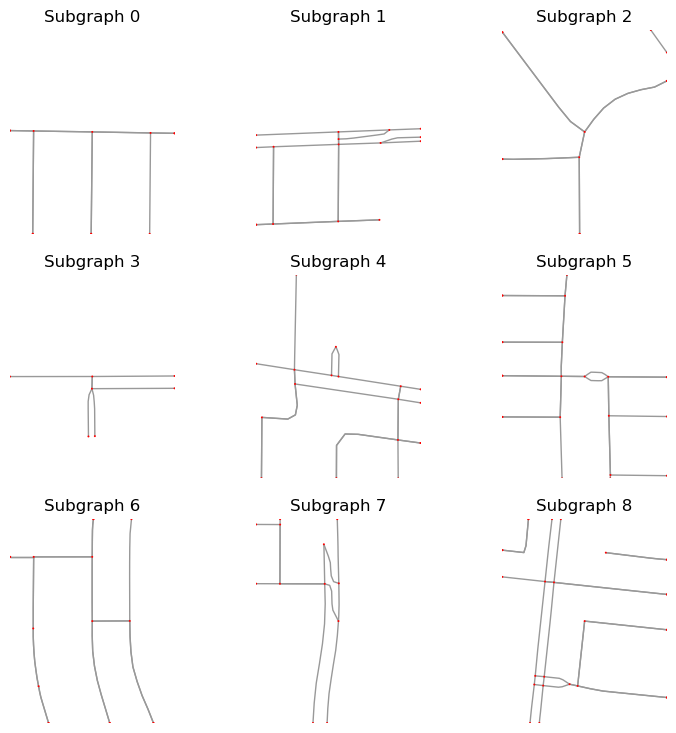

In [11]:
# Draw 9 subgraphs
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = axs[i, j]
        ax.set_title(f"Subgraph {idx}")
        ox.plot_graph(sub_graphs[idx], node_size=2, edge_linewidth=1, ax=ax, show=False, node_color="red")
        ax.set_xlim((graph_bboxes[idx][2], graph_bboxes[idx][3]))
        ax.set_ylim((graph_bboxes[idx][0], graph_bboxes[idx][1]))

plt.show()

# Generate Routes and Trajectories

In [12]:
N_trajs = 48
max_visited_num = 8
min_traj_len = 8
max_traj_len = 16
# noise_std = 0.000025   # hard
noise_std = 0.00002   # medium
# noise_std = 0.000015   # easy

In [13]:
def myLineMerge(geom_list):
    # Used for concatenating multiple LineString (head-tail, head-head, tail-tail or tail-head)
    result = list(geom_list[0].coords)
    for geom in geom_list[1:]:
        if result[-1] == geom.coords[0]:
            result += list(geom.coords[1:])
        elif result[-1] == geom.coords[-1]:
            result += list(geom.coords[::-1][1:])
        elif result[0] == geom.coords[0]:
            result = list(geom.coords[::-1]) + result[1:]
        elif result[0] == geom.coords[-1]:
            result = list(geom.coords) + result[1:]
    return LineString(result)

In [ ]:
all_routes = np.zeros((data_count, N_trajs, max_visited_num, interp_n, 2), np.float32)
all_trajs = np.zeros((data_count, N_trajs, max_traj_len, 2), np.float32)

all_traj_lens = np.random.randint(min_traj_len, max_traj_len, (data_count, N_trajs))

if debug:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            axes[i, j].set_title(f"Subgraph {idx}")
            axes[i, j].set_xlim((graph_bboxes[idx][2], graph_bboxes[idx][3]))
            axes[i, j].set_ylim((graph_bboxes[idx][0], graph_bboxes[idx][1]))
            for seg in all_segs[idx]:
                axes[i, j].plot(seg[:, 0], seg[:, 1], color="black", linewidth=6)

pbar = tqdm(sub_graphs)
for b, graph in enumerate(pbar):
    edges = [(u, v, data) for u, v, data in graph.edges(data=True)]
    edges_weight = np.array([data["geometry"].length for u, v, data in edges])
    edges_weight /= edges_weight.sum()
    unvisited_edges = [(u, v) for u, v in graph.edges()]
    for i in range(N_trajs):
        # first, make sure each node is chosen at least once
        if len(unvisited_edges) != 0:
            start_edge = unvisited_edges.pop()
        else:
            edge_id = int(np.random.choice(range(len(edges)), p=edges_weight))
            start_edge = edges[edge_id]
        
        visit_nodes = [start_edge[0], start_edge[1]]

        # random walk
        visit_geoms = [graph.get_edge_data(visit_nodes[0], visit_nodes[1])[0]["geometry"]]
        for j in range(1, max_visited_num):
            neighbors = list(graph.neighbors(visit_nodes[-1]))
            if len(neighbors) <= 1:
                visit_nodes = visit_nodes[::-1]     # flip
                visit_geoms = visit_geoms[::-1]     # flip
                # Lets's try to explore the other direction
                neighbors = list(graph.neighbors(visit_nodes[-1]))
                if len(neighbors) <= 1:
                    break

            # choose unvisited edge first
            for neighbor in neighbors:
                if (visit_nodes[-1], neighbor) in unvisited_edges or (neighbor, visit_nodes[-1]) in unvisited_edges:
                    next_node = neighbor
                    break
            else:
                prev_node = visit_nodes[-2]
                go_back_id = neighbors.index(prev_node)
                # longer distance, larger weight
                weight = np.array([graph.get_edge_data(visit_nodes[-1], v)[0]["geometry"].length for v in neighbors])
                weight[go_back_id] *= 0.1
                next_node_id = int(np.random.choice(range(len(neighbors)), p=weight / weight.sum()))
                next_node = neighbors[next_node_id]

            visit_nodes.append(next_node)
            edge_data = list(graph.get_edge_data(visit_nodes[-2], visit_nodes[-1]).values())
            visit_geoms.append(random.choice(edge_data)["geometry"])

            if len(unvisited_edges) != 0:
                if (visit_nodes[-2], visit_nodes[-1]) in unvisited_edges:
                    unvisited_edges.remove((visit_nodes[-2], visit_nodes[-1]))
                elif (visit_nodes[-1], visit_nodes[-2]) in unvisited_edges:
                    unvisited_edges.remove((visit_nodes[-1], visit_nodes[-2]))

        # Merge geometries
        # route = ops.linemerge(visit_geoms)
        visit_points = myLineMerge(visit_geoms)

        # pbar.set_postfix_str(f"RouteLen={len(route.coords)}, VisitNum={len(visit_geoms)}")

        # interp_distances = np.linspace(0, visit_points.length, all_traj_lens[b, i])
        interp_distances = np.sort(np.concatenate([
            np.linspace(0, visit_points.length, 6),
            np.random.uniform(0, visit_points.length, all_traj_lens[b, i] - 6)
        ]))
        interp_points = [visit_points.interpolate(d) for d in interp_distances]

        traj = np.array([p.coords[0] for p in interp_points])
        traj += np.random.normal(0, noise_std, traj.shape)

        all_routes[b, i, :len(visit_geoms), :] = np.stack([np.array(geom.coords) for geom in visit_geoms], axis=0)
        all_trajs[b, i, :all_traj_lens[b, i], :] = traj

        # plot route
        if debug:
            row = b // 3
            col = b % 3
            axes[row, col].plot(*visit_points.xy, color="cyan", linewidth=2, alpha=0.5)
            # plot trajectory
            axes[row, col].plot(all_trajs[b, i, :all_traj_lens[b, i], 0], all_trajs[b, i, :all_traj_lens[b, i], 1], 
                                color="red", linewidth=1, alpha=0.5)

    if len(unvisited_edges) != 0:
        print(f"Warning! {len(unvisited_edges)} edges are not visited!")
        fig, ax = ox.plot_graph(sub_graphs[b], node_size=2, edge_linewidth=1, show=False, node_color="red", figsize=(4, 4))
        ax.set_xlim((graph_bboxes[b][2], graph_bboxes[b][3]))
        ax.set_ylim((graph_bboxes[b][0], graph_bboxes[b][1]))
        for k in range(N_trajs):
            plt.plot(all_trajs[b, k, :all_traj_lens[idx, k], 0], 
                     all_trajs[b, k, :all_traj_lens[idx, k], 1], alpha=0.5, marker=".", linewidth=1)
        plt.show()

np.save("all_routes.npy", all_routes)
np.save("all_trajs.npy", all_trajs)

if debug:
    plt.show()

 24%|██▎       | 2365/9997 [00:26<01:23, 91.06it/s]

In [ ]:
# Draw 9 subgraphs
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = axs[i, j]
        ax.set_title(f"Subgraph {idx}")
        for k in range(N_trajs):
            ax.scatter(all_trajs[idx, k, :all_traj_lens[idx, k], 0], 
                    all_trajs[idx, k, :all_traj_lens[idx, k], 1], alpha=0.2, marker=".")#, linewidth=1)
        ax.set_xlim((graph_bboxes[idx][2], graph_bboxes[idx][3]))
        ax.set_ylim((graph_bboxes[idx][0], graph_bboxes[idx][1]))

plt.show()

# Switch to Another Kernel (Needed: cv2, torch)

In [1]:
import numpy as np
import torch
import requests
import cv2
import threading
import os
import json
from tqdm import tqdm
from torch.nn.functional import pad, interpolate
import matplotlib.pyplot as plt

debug = False

# Load and Reformat Data

In [2]:
all_segs = torch.tensor(np.load("all_segs.npy"))    # (B, N_segs, N_interp, 2)
all_routes = torch.tensor(np.load("all_routes.npy"))    # (B, N_trajs, L_route, N_interp, 2)
all_trajs = torch.tensor(np.load("all_trajs.npy"))  
graph_bboxes = np.load("graph_bboxes.npy")

data_count = all_segs.shape[0]
N_trajs = all_routes.shape[1]
N_segs = all_segs.shape[1]
max_route_len = all_routes.shape[2]
max_traj_len = all_trajs.shape[2]

print(f"{data_count=}\n{N_trajs=}\n{max_route_len=}\n{max_traj_len=}")

traj_lens = torch.sum(torch.all(all_trajs != 0, dim=-1), dim=-1)
route_lens = torch.sum(torch.all(all_routes.flatten(-2, -1) != 0, dim=-1), dim=-1)
seg_nums = torch.sum(torch.all(all_segs.flatten(-2, -1) != 0, dim=-1), dim=-1)  # (B,)

print(traj_lens.shape)
print(route_lens.shape)
print(seg_nums.shape)

if not debug:
    all_mean = torch.zeros(data_count, 1, 1, 2, dtype=torch.float32)
    all_std = torch.zeros(data_count, 1, 1, 2, dtype=torch.float32)

    for b in tqdm(range(data_count)):
        # (N_points, 2)
        traj_points = torch.cat([all_trajs[b, i, :traj_lens[b, i]] for i in range(N_trajs)], dim=0)
        mean_point = traj_points.mean(dim=0).view(1, 1, 2)
        std_point = traj_points.std(dim=0).view(1, 1, 2)
        all_mean[b] = mean_point
        all_std[b] = std_point
        for traj_i in range(N_trajs):
            valid_len = traj_lens[b, traj_i]
            all_trajs[b, traj_i, :valid_len] = (all_trajs[b, traj_i, :valid_len] - mean_point) / std_point
            
            valid_len = route_lens[b, traj_i]
            all_routes[b, traj_i, :valid_len] = (all_routes[b, traj_i, :valid_len] - mean_point.unsqueeze(0)) / std_point.unsqueeze(0)
            for seg_i in range(valid_len):
                # Ensure the unique direction of segments
                if all_routes[b, traj_i, seg_i, 0, 0] > all_routes[b, traj_i, seg_i, -1, 0]:
                    all_routes[b, traj_i, seg_i] = all_routes[b, traj_i, seg_i].flip(0)

        valid_len = seg_nums[b]
        all_segs[b, :valid_len] = (all_segs[b, :valid_len] - mean_point) / std_point
        for seg_i in range(valid_len):
            if all_segs[b, seg_i, 0, 0] > all_segs[b, seg_i, -1, 0]:
                all_segs[b, seg_i] = all_segs[b, seg_i].flip(0)

data_count=10000
N_trajs=48
max_route_len=8
max_traj_len=16
torch.Size([10000, 48])
torch.Size([10000, 48])
torch.Size([10000])


100%|██████████| 10000/10000 [00:24<00:00, 406.70it/s]


# Prepare Image download

In [3]:
# This code block is from https://github.com/andolg/satellite-imagery-downloader
cache_dict = dict()
def get_downloader_with_cache(url, headers, channels, zoom):
    def download_tile(tile_x, tile_y):
        global cache_dict
        key = (tile_x, tile_y)
        if key in cache_dict:
            return cache_dict[key]
        else:
            response = requests.get(url.format(x=tile_x, y=tile_y, z=zoom), headers=headers)
            arr = np.asarray(bytearray(response.content), dtype=np.uint8)
        
            if channels == 3:
                result = cv2.imdecode(arr, 1)
            else:
                result = cv2.imdecode(arr, -1)
            cache_dict[(tile_x, tile_y)] = result
            return result
            
    return download_tile

# Mercator projection
# https://developers.google.com/maps/documentation/javascript/examples/map-coordinates
def project_with_scale(lat, lon, scale):
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    x = scale * (0.5 + lon / 360)
    y = scale * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    return x, y

def download_image(lat1: float, lon1: float, lat2: float, lon2: float,
                   zoom: int, url: str, headers: dict, tile_size: int = 256, channels: int = 3) -> np.ndarray:
    """
    Downloads a map region. Returns an image stored as a `numpy.ndarray` in BGR or BGRA, depending on the number
    of `channels`.

    Parameters
    ----------
    `(lat1, lon1)` - Coordinates (decimal degrees) of the top-left corner of a rectangular area

    `(lat2, lon2)` - Coordinates (decimal degrees) of the bottom-right corner of a rectangular area

    `zoom` - Zoom level

    `url` - Tile URL with {x}, {y} and {z} in place of its coordinate and zoom values

    `headers` - Dictionary of HTTP headers

    `tile_size` - Tile size in pixels

    `channels` - Number of channels in the output image. Also affects how the tiles are converted into numpy arrays.
    """

    scale = 1 << zoom

    # Find the pixel coordinates and tile coordinates of the corners
    tl_proj_x, tl_proj_y = project_with_scale(lat1, lon1, scale)
    br_proj_x, br_proj_y = project_with_scale(lat2, lon2, scale)

    tl_pixel_x = int(tl_proj_x * tile_size)
    tl_pixel_y = int(tl_proj_y * tile_size)
    br_pixel_x = int(br_proj_x * tile_size)
    br_pixel_y = int(br_proj_y * tile_size)

    tl_tile_x = int(tl_proj_x)
    tl_tile_y = int(tl_proj_y)
    br_tile_x = int(br_proj_x)
    br_tile_y = int(br_proj_y)

    img_w = abs(tl_pixel_x - br_pixel_x)
    img_h = br_pixel_y - tl_pixel_y
    img = np.zeros((img_h, img_w, channels), np.uint8)

    downloader = get_downloader_with_cache(url, headers, channels, zoom)

    def build_row(tile_y):
        for tile_x in range(tl_tile_x, br_tile_x + 1):
            tile = downloader(tile_x, tile_y)

            if tile is not None:
                # Find the pixel coordinates of the new tile relative to the image

                tl_rel_x = tile_x * tile_size - tl_pixel_x
                tl_rel_y = tile_y * tile_size - tl_pixel_y
                br_rel_x = tl_rel_x + tile_size
                br_rel_y = tl_rel_y + tile_size

                # Define where the tile will be placed on the image
                img_x_l = max(0, tl_rel_x)
                img_x_r = min(img_w + 1, br_rel_x)
                img_y_l = max(0, tl_rel_y)
                img_y_r = min(img_h + 1, br_rel_y)

                # Define how border tiles will be cropped
                cr_x_l = max(0, -tl_rel_x)
                cr_x_r = tile_size + min(0, img_w - br_rel_x)
                cr_y_l = max(0, -tl_rel_y)
                cr_y_r = tile_size + min(0, img_h - br_rel_y)

                img[img_y_l:img_y_r, img_x_l:img_x_r] = tile[cr_y_l:cr_y_r, cr_x_l:cr_x_r]

    
    for tile_y in range(tl_tile_y, br_tile_y + 1):
        build_row(tile_y)
    return img

prefs = {
    'url': 'https://mt.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    'tile_size': 256,
    'channels': 3,
    'dir': 'images',
    'headers': {
        'cache-control': 'max-age=0',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="99", "Google Chrome";v="99"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'none',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.82 Safari/537.36'
    },
    'tl': '',
    'br': '',
    'zoom': ''
}

# with open(prefs_path, 'w', encoding='utf-8') as f:
#     json.dump(default_prefs, f, indent=2, ensure_ascii=False)
# 
# with open('preferences.json', 'r', encoding='utf-8') as f:
#     prefs = json.loads(f.read())

# zoom_levels = [
#     78271.52, 39135.76, 19567.88, 9783.94, 4891.97, 2445.98, 1222.99, 611.50, 305.75, 152.87, # 1 - 10
#     76.44, 38.22, 19.11, 9.55, 4.78, 2.39, 1.19, 0.60, 0.30 # 11 - 19
# ]

# Download Images and Generate Heatmaps

In [4]:
n_threads = 4
images = [[] for _ in range(n_threads)]
progress = [0 for _ in range(n_threads)]
total = 0

def download_images(task_i, start, stop):
    global progress
    global total
    global images
    print(task_i, start, stop)
    for b in range(start, stop):
        min_lat, max_lat, min_lon, max_lon = graph_bboxes[b]
        top, left, bottom, right = max_lat, min_lon, min_lat, max_lon
        img = download_image(top, left, bottom, right, 17, prefs['url'], prefs['headers'], int(prefs['tile_size']), int(prefs['channels']))
        images[task_i].append(torch.tensor(img, dtype=torch.float32).flip(0) / 255)
        progress[task_i] += 1
        total += 1

threads = []

base_size = data_count // n_threads
start = 0
for i in range(n_threads):
    if i == n_threads - 1:
        end = data_count
    else:
        end = start + base_size
    thread = threading.Thread(target=download_images, args=[i, start, end])
    thread.start()
    threads.append(thread)
    start = end
    threading.Event().wait(0.1)

print("Downloading images")

while total < data_count:
    print(f"\r{total:05d}/{data_count}\t" + " ".join([f"{each:04d}" for each in progress]), end="")
    threading.Event().wait(0.1)

for thread in threads:
    thread.join()

0 0 2500
1 2500 5000
2 5000 7500
3 7500 10000
09979/10000	2500 2500 2479 2500

In [5]:
images = sum(images, [])

# Generate Heatmaps

In [6]:
h, w = 256, 256

heatmaps = []
for b in tqdm(range(data_count), desc="Generating heatmaps"):
    trajs = all_trajs[b]
    traj_len = traj_lens[b]
    if traj_len[i] != 0:
        points = torch.cat([trajs[i, :traj_len[i]] for i in range(N_trajs)], dim=0)
        min_point = torch.min(points, dim=0, keepdim=True).values
        max_point = torch.max(points, dim=0, keepdim=True).values
        point_range = max_point - min_point
    
        norm_points = (points - min_point) / point_range
    
        x_ids = (norm_points[:, 0] * (w - 1)).long()
        y_ids = (norm_points[:, 1] * (h - 1)).long()
        heatmap_flat = torch.zeros(h * w, dtype=torch.float32)
        flat_indices = y_ids * w + x_ids
        heatmap_flat.scatter_add_(0, flat_indices, torch.ones_like(flat_indices, dtype=torch.float32))
        heatmaps.append(heatmap_flat.view(h, w))
    else:
        heatmaps.append(torch.zeros(h, w, dtype=torch.float32))

Generating heatmaps: 100%|██████████| 10000/10000 [00:02<00:00, 4520.00it/s]


In [7]:
# plot images
if debug:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        for j in range(3):
            b = i * 3 + j
            img_with_heat = images[b].clone()
            img_with_heat[..., 0] += heatmaps[b]
            min_lat, max_lat, min_lon, max_lon = graph_bboxes[b]
            axes[i, j].imshow(img_with_heat, origin="lower", extent=(min_lon, max_lon, min_lat, max_lat))
            axes[i, j].axis("equal")
            for k in range(N_trajs):
                for route in all_routes[b, k]:
                    if not torch.all(route == 0):
                        axes[i, j].plot(route[:, 0], route[:, 1], color="red", alpha=0.5)
                traj = all_trajs[b, k]
                non_zeros = torch.all(traj != 0, dim=1)
                axes[i, j].plot(traj[non_zeros, 0], traj[non_zeros, 1], color="blue", alpha=0.2)

    plt.show()


# Resize and Save

In [8]:
max_h = 0
max_w = 0
for b in range(data_count):
    h, w = images[b].shape[:2]
    max_h = max(max_h, h)
    max_w = max(max_w, w)
print(max_h, max_w)

278 224


In [9]:
resize = max(max_h, max_w)
print(resize)

target_size = 256

278


In [10]:
for b in tqdm(range(data_count)):
    h, w = images[b].shape[:2]
    # pad_h = pad_size - h
    # pad_w = pad_size - w
    # images[b] = pad(images[b].permute(2, 0, 1), (0, pad_h, 0, pad_w))
    # heatmaps[b] = pad(heatmaps[b].unsqueeze(0), (0, pad_h, 0, pad_w))

    images[b] = interpolate(images[b].permute(2, 0, 1).unsqueeze(0), (resize, resize), mode="bilinear", align_corners=False).squeeze(0)
    heatmaps[b] = interpolate(heatmaps[b].unsqueeze(0).unsqueeze(0), (resize, resize), mode="bilinear", align_corners=False).squeeze(0)
    
torch.save({
    "segs": all_segs.to(torch.float32),
    "routes": all_routes,
    "trajs": all_trajs,
    "point_mean": all_mean,
    "point_std": all_std,
    "bboxes": torch.tensor(graph_bboxes).to(torch.float32),
    "traj_lens": traj_lens,
    "route_lens": route_lens,
    "seg_nums": seg_nums,
    "images": torch.stack(images, dim=0),
    "heatmaps": torch.stack(heatmaps, dim=0)
}, "dataset.pt")

100%|██████████| 10000/10000 [00:02<00:00, 3671.44it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


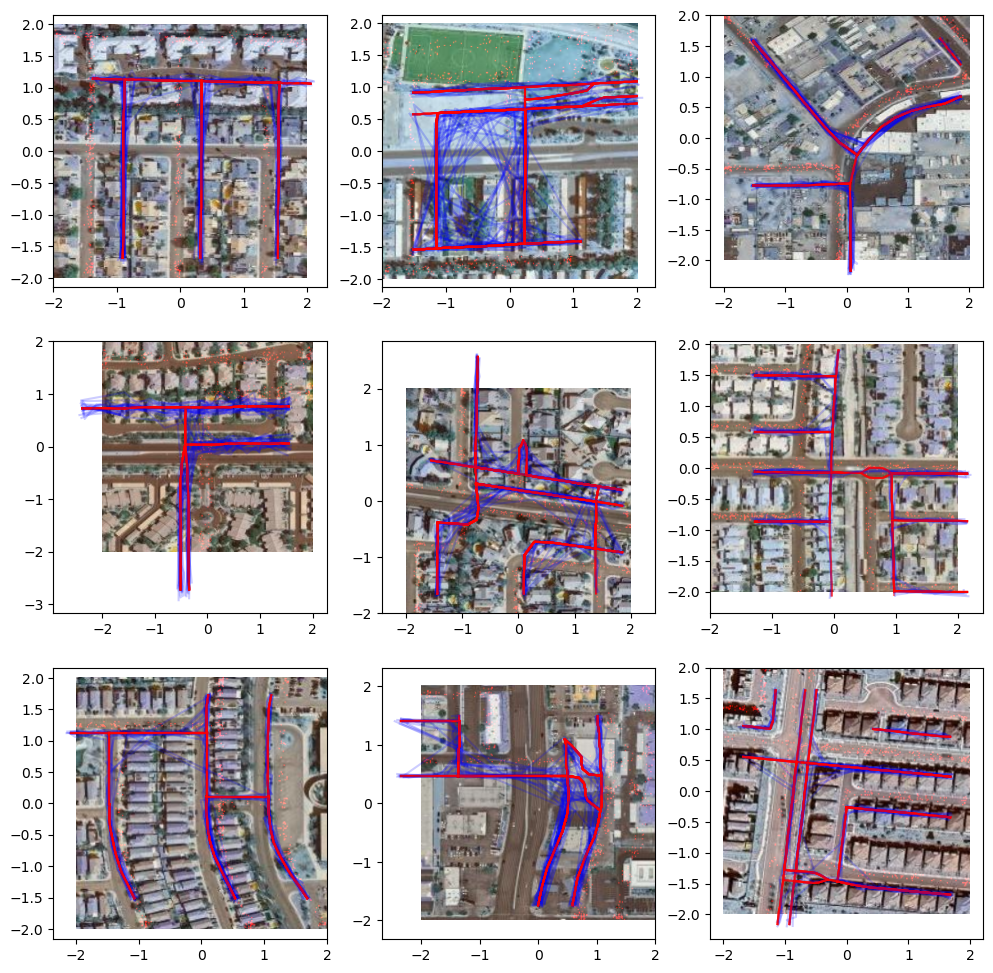

In [11]:
# plot images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        b = i * 3 + j
        img_with_heat = images[b].permute(1, 2, 0).clone()
        img_with_heat[..., 0] += heatmaps[b][0]
        min_lat, max_lat, min_lon, max_lon = graph_bboxes[b]
        axes[i, j].imshow(img_with_heat, origin="lower", extent=(-2, 2, -2, 2))
        axes[i, j].axis("equal")
        for k in range(N_trajs):
            route = all_routes[b, k]
            for seg_i in range(len(route)):
                axes[i, j].plot(route[seg_i, :, 0], route[seg_i, :, 1], color="red", alpha=0.5)
            traj = all_trajs[b, k]
            non_zeros = torch.all(traj != 0, dim=1)
            axes[i, j].plot(traj[non_zeros, 0], traj[non_zeros, 1], color="blue", alpha=0.2)

plt.show()